라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 2
model_name = 'Test230725_tank2_lstm_crop720_only-feed'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [7]:
japonica_training_features_X = japonica_training_data[['feed_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [8]:
japonica_training_features_X_chunks = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_training_features_X_chunks = japonica_training_features_X_chunks.reshape((-1, 720, 1))
japonica_training_features_y_chunks = np.asarray(japonica_training_features_y, dtype=np.float64)
japonica_training_features_y_chunks = japonica_training_features_y_chunks.reshape((-1, 720, 1))

japonica_validation_features_X_chunks = np.asarray(japonica_validation_features_X, dtype=np.float64)
japonica_validation_features_X_chunks = japonica_validation_features_X_chunks.reshape((-1, 720, 1))
japonica_validation_features_y_chunks = np.asarray(japonica_validation_features_y, dtype=np.float64)
japonica_validation_features_y_chunks = japonica_validation_features_y_chunks.reshape((-1, 720, 1))

In [9]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 90 nVar: 1
nCar: 90 nVar: 720
nCar: 90 nVar: 1
nCar: 90 nVar: 720


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [10]:
# LSTM 모델 생성
model = Sequential()
model.add(LSTM(128, input_shape=(720, 1), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(720, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks, japonica_training_features_y_chunks, epochs = 1000, batch_size = 32, validation_data=(japonica_validation_features_X_chunks, japonica_validation_features_y_chunks), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

2023-07-24 15:53:54.713167: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 15:53:55.360654: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 720, 128)          66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 720, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 720)               23760     
Total params: 152,144
Trainable params: 152,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000


2023-07-24 15:53:56.239795: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-24 15:53:59.758145: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-07-24 15:54:00.700032: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 6s 648ms/step - loss: 80.8522 - mae: 8.8380 - r_squared: -30.1979 - val_loss: 80.7912 - val_mae: 8.8345 - val_r_squared: -35.8797
Epoch 2/1000
3/3 [==============================] - 0s 190ms/step - loss: 80.7374 - mae: 8.8314 - r_squared: -30.3959 - val_loss: 80.5337 - val_mae: 8.8199 - val_r_squared: -35.7630
Epoch 3/1000
3/3 [==============================] - 0s 188ms/step - loss: 80.2703 - mae: 8.8052 - r_squared: -29.2339 - val_loss: 79.3089 - val_mae: 8.7497 - val_r_squared: -35.2078
Epoch 4/1000
3/3 [==============================] - 0s 158ms/step - loss: 78.8329 - mae: 8.7220 - r_squared: -29.6378 - val_loss: 77.8784 - val_mae: 8.6667 - val_r_squared: -34.5591
Epoch 5/1000
3/3 [==============================] - 0s 173ms/step - loss: 77.4405 - mae: 8.6409 - r_squared: -30.3639 - val_loss: 76.4092 - val_mae: 8.5811 - val_r_squared: -33.8931
Epoch 6/1000
3/3 [==============================] - 0s 161ms/step - loss: 75.9087 - mae: 8.5517 - r_squ

Epoch 46/1000
3/3 [==============================] - 0s 161ms/step - loss: 21.4134 - mae: 4.3150 - r_squared: -7.0314 - val_loss: 20.9524 - val_mae: 4.2610 - val_r_squared: -8.6385
Epoch 47/1000
3/3 [==============================] - 0s 158ms/step - loss: 20.7413 - mae: 4.2369 - r_squared: -6.6296 - val_loss: 20.2957 - val_mae: 4.1834 - val_r_squared: -8.3368
Epoch 48/1000
3/3 [==============================] - 0s 193ms/step - loss: 20.0965 - mae: 4.1593 - r_squared: -6.6427 - val_loss: 19.6532 - val_mae: 4.1061 - val_r_squared: -8.0415
Epoch 49/1000
3/3 [==============================] - 1s 210ms/step - loss: 19.4499 - mae: 4.0826 - r_squared: -6.3412 - val_loss: 19.0369 - val_mae: 4.0305 - val_r_squared: -7.7581
Epoch 50/1000
3/3 [==============================] - 0s 196ms/step - loss: 18.8409 - mae: 4.0073 - r_squared: -6.1020 - val_loss: 18.4392 - val_mae: 3.9559 - val_r_squared: -7.4831
Epoch 51/1000
3/3 [==============================] - 0s 190ms/step - loss: 18.2506 - mae: 3.932

3/3 [==============================] - 1s 210ms/step - loss: 5.5560 - mae: 1.8254 - r_squared: -1.0615 - val_loss: 5.4608 - val_mae: 1.8054 - val_r_squared: -1.4472
Epoch 92/1000
3/3 [==============================] - 1s 223ms/step - loss: 5.4181 - mae: 1.7967 - r_squared: -0.9928 - val_loss: 5.3318 - val_mae: 1.7779 - val_r_squared: -1.3857
Epoch 93/1000
3/3 [==============================] - 0s 187ms/step - loss: 5.2939 - mae: 1.7700 - r_squared: -0.9321 - val_loss: 5.2064 - val_mae: 1.7512 - val_r_squared: -1.3259
Epoch 94/1000
3/3 [==============================] - 0s 207ms/step - loss: 5.1720 - mae: 1.7440 - r_squared: -0.9305 - val_loss: 5.0866 - val_mae: 1.7258 - val_r_squared: -1.2686
Epoch 95/1000
3/3 [==============================] - 0s 185ms/step - loss: 5.0452 - mae: 1.7176 - r_squared: -0.9359 - val_loss: 4.9735 - val_mae: 1.7017 - val_r_squared: -1.2144
Epoch 96/1000
3/3 [==============================] - 1s 234ms/step - loss: 4.9370 - mae: 1.6946 - r_squared: -0.8749 - 

Epoch 137/1000
3/3 [==============================] - 0s 153ms/step - loss: 2.8856 - mae: 1.2591 - r_squared: -0.0784 - val_loss: 2.8746 - val_mae: 1.2565 - val_r_squared: -0.1788
Epoch 138/1000
3/3 [==============================] - 0s 167ms/step - loss: 2.8702 - mae: 1.2555 - r_squared: -0.0610 - val_loss: 2.8609 - val_mae: 1.2538 - val_r_squared: -0.1714
Epoch 139/1000
3/3 [==============================] - 0s 151ms/step - loss: 2.8557 - mae: 1.2532 - r_squared: -0.0439 - val_loss: 2.8478 - val_mae: 1.2514 - val_r_squared: -0.1644
Epoch 140/1000
3/3 [==============================] - 0s 154ms/step - loss: 2.8435 - mae: 1.2505 - r_squared: -0.0420 - val_loss: 2.8352 - val_mae: 1.2490 - val_r_squared: -0.1575
Epoch 141/1000
3/3 [==============================] - 0s 202ms/step - loss: 2.8317 - mae: 1.2484 - r_squared: -0.0409 - val_loss: 2.8230 - val_mae: 1.2468 - val_r_squared: -0.1509
Epoch 142/1000
3/3 [==============================] - 0s 163ms/step - loss: 2.8191 - mae: 1.2461 - r

Epoch 183/1000
3/3 [==============================] - 1s 204ms/step - loss: 2.6389 - mae: 1.2330 - r_squared: -0.0089 - val_loss: 2.6380 - val_mae: 1.2332 - val_r_squared: -0.0405
Epoch 184/1000
3/3 [==============================] - 0s 191ms/step - loss: 2.6376 - mae: 1.2332 - r_squared: -0.0836 - val_loss: 2.6374 - val_mae: 1.2334 - val_r_squared: -0.0401
Epoch 185/1000
3/3 [==============================] - 0s 183ms/step - loss: 2.6371 - mae: 1.2335 - r_squared: 0.0328 - val_loss: 2.6365 - val_mae: 1.2338 - val_r_squared: -0.0394
Epoch 186/1000
3/3 [==============================] - 0s 183ms/step - loss: 2.6360 - mae: 1.2338 - r_squared: 0.0253 - val_loss: 2.6357 - val_mae: 1.2341 - val_r_squared: -0.0388
Epoch 187/1000
3/3 [==============================] - 1s 212ms/step - loss: 2.6357 - mae: 1.2342 - r_squared: 0.0173 - val_loss: 2.6349 - val_mae: 1.2344 - val_r_squared: -0.0381
Epoch 188/1000
3/3 [==============================] - 0s 189ms/step - loss: 2.6350 - mae: 1.2346 - r_sq

3/3 [==============================] - 0s 206ms/step - loss: 2.6260 - mae: 1.2429 - r_squared: 0.0278 - val_loss: 2.6260 - val_mae: 1.2429 - val_r_squared: -0.0289
Epoch 229/1000
3/3 [==============================] - 0s 166ms/step - loss: 2.6260 - mae: 1.2429 - r_squared: 0.0343 - val_loss: 2.6260 - val_mae: 1.2429 - val_r_squared: -0.0289
Epoch 230/1000
3/3 [==============================] - 0s 191ms/step - loss: 2.6260 - mae: 1.2429 - r_squared: -0.0102 - val_loss: 2.6260 - val_mae: 1.2429 - val_r_squared: -0.0289

Epoch 00230: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 231/1000
3/3 [==============================] - 0s 199ms/step - loss: 2.6260 - mae: 1.2429 - r_squared: -0.0020 - val_loss: 2.6260 - val_mae: 1.2429 - val_r_squared: -0.0289
Epoch 232/1000
3/3 [==============================] - 0s 191ms/step - loss: 2.6260 - mae: 1.2429 - r_squared: 0.0418 - val_loss: 2.6260 - val_mae: 1.2429 - val_r_squared: -0.0289
Epoch 233/1000
3/3 [================

모델 평가

In [11]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [12]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[-0.07393119 -0.04444257  0.04302103  0.0763393   0.06112713  0.08720764
  -0.00737832  0.06851216 -0.06227142  0.10682628  0.02222774  0.03795999
   0.07877084 -0.02594662 -0.09659781 -0.05777988  0.04222097 -0.08352604
   0.0922794   0.06614283  0.08287895  0.06746013  0.07123048  0.03008042
   0.04623627  0.0575721  -0.0769137  -0.10241268 -0.08994235  0.10558613
   0.08960607 -0.07465938 -0.05338405  0.04749348 -0.03132718  0.0326953
   0.10347901  0.03703506  0.01584681  0.03371133 -0.09633545  0.07330852
  -0.05904078  0.03770477  0.05717435 -0.07206167  0.01089382  0.04712614
  -0.10190006  0.0579185   0.00346253  0.00212959  0.04111424 -0.1043179
  -0.01863205  0.07738931 -0.0454012  -0.0205837  -0.06748778  0.08932422
  -0.02676625 -0.05438822 -0.02163993 -0.07893209  0.02512131 -0.027672
  -0.00611556  0.09369994  0.01499211  0.04344799 -0.03554473 -0.04694634
  -0.04082199 -0.09457685  0.10190701  0.01785241 -0.08127115  0.04312268
  -0.10641465 -0.06904201 -0.07662766  0.0

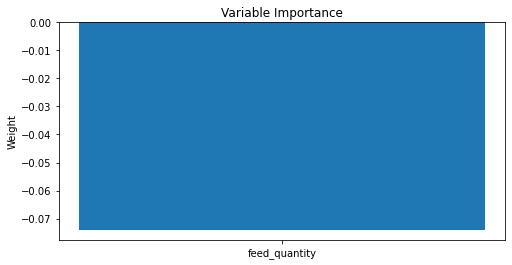

In [13]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(1), weights[:, 0])
ax.set_xticks(range(1))
ax.set_xticklabels(['feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [14]:
japonica_validation_features_X

,feed_quantity
mea_dt,
2021-07-21 00:00:00,0.0
2021-07-21 00:01:00,0.0
2021-07-21 00:02:00,0.0
2021-07-21 00:03:00,0.0
2021-07-21 00:04:00,0.0
...,...
2021-09-08 23:55:00,0.0
2021-09-08 23:56:00,0.0
2021-09-08 23:57:00,0.0


In [15]:
X = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-08 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 90 nVar: 1


In [16]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 1
nCar: 90 nVar: 720


64800


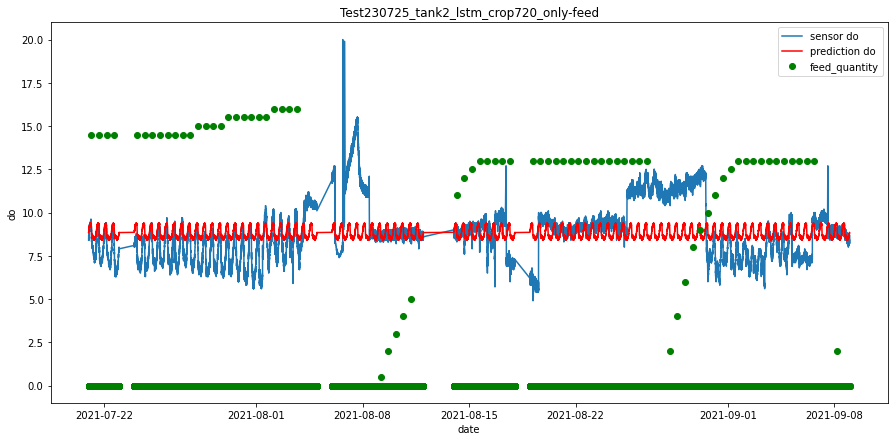

3/3 [==============================] - 1s 31ms/step - loss: 2.6260 - mae: 1.2429 - r_squared: -0.0289
MSE // MAE // R-squared  [2.6259853839874268, 1.2429397106170654, -0.028865298256278038]


In [17]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [18]:
X = japonica_validation_data.loc['2021-08-02 00:00':'2021-08-03 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 1


In [19]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 2880 nVar: 1
nCar: 4 nVar: 720


2880


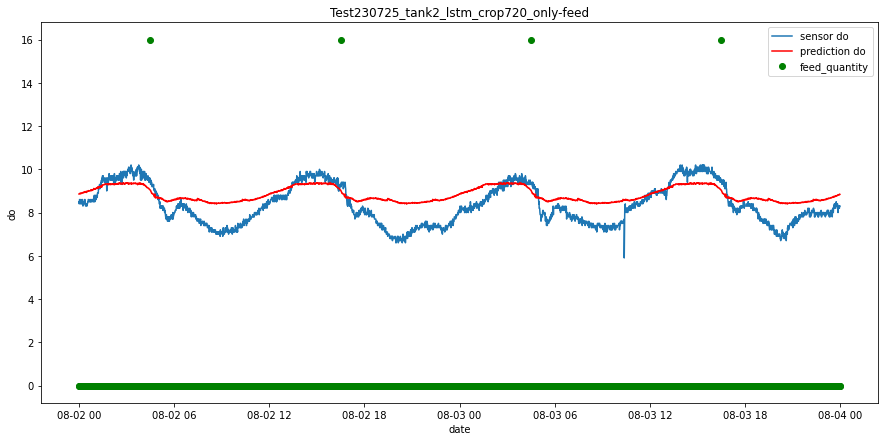

1/1 [==============================] - 0s 51ms/step - loss: 0.6222 - mae: 0.6664 - r_squared: 0.2726
MSE // MAE // R-squared  [0.6221557259559631, 0.6664002537727356, 0.2725534439086914]


In [20]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [21]:
X = japonica_validation_data.loc['2021-08-01 00:00':'2021-08-08 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14 nVar: 1


In [22]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 10080 nVar: 1
nCar: 14 nVar: 720


10080


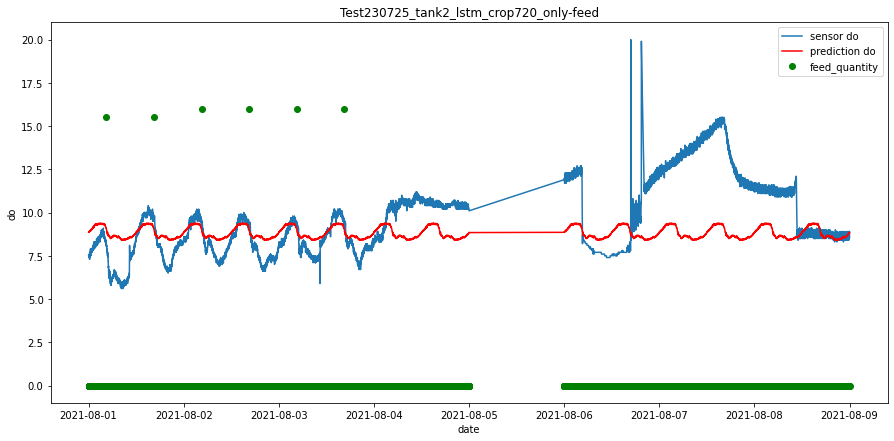

1/1 [==============================] - 0s 60ms/step - loss: 5.2300 - mae: 1.6904 - r_squared: -0.1181
MSE // MAE // R-squared  [5.229959011077881, 1.6904038190841675, -0.11810362339019775]


In [23]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [24]:
X = japonica_validation_data.loc['2021-08-03 00:00':'2021-08-03 11:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1 nVar: 1


In [25]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 1 nVar: 720


720


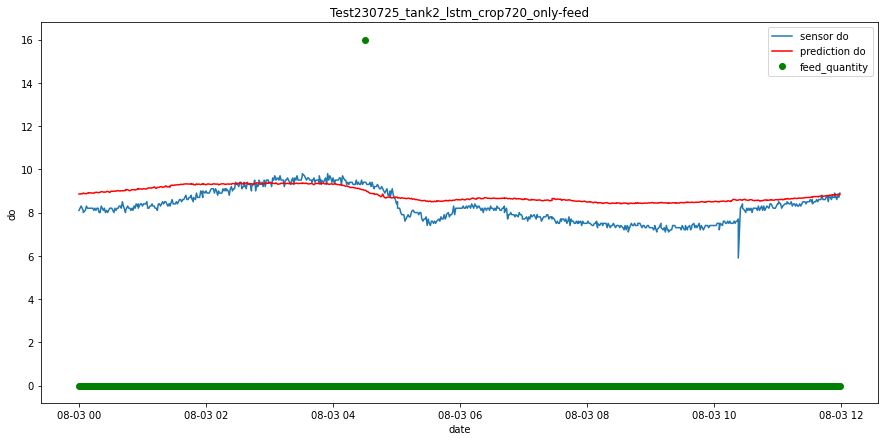

1/1 [==============================] - 0s 64ms/step - loss: 0.5125 - mae: 0.6131 - r_squared: 0.0286
MSE // MAE // R-squared  [0.5124505758285522, 0.6130712628364563, 0.028638780117034912]


In [26]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

nCar: 1 nVar: 1
nCar: 720 nVar: 1
nCar: 1 nVar: 720
720


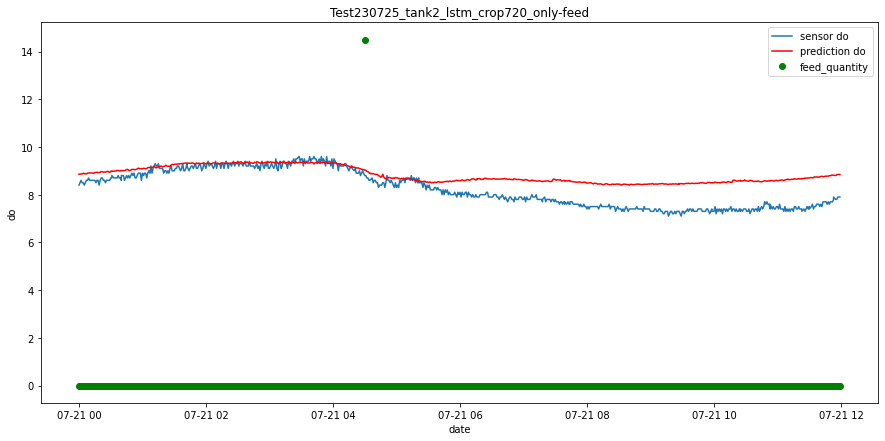

1/1 [==============================] - 0s 71ms/step - loss: 0.5600 - mae: 0.6032 - r_squared: 0.0316
MSE // MAE // R-squared  [0.5599932074546814, 0.6031929850578308, 0.03163647651672363]


In [27]:
X = japonica_validation_data.loc['2021-07-21 00:00':'2021-07-21 11:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)